In [4]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))


from data import get_dataloaders
from models.cnn import ConvMLP
from models.mlp import MLP

In [5]:
class ActivationLogger:
    """
    Capture the output (activations) of selected modules using forward hooks.
    Stores a 1D snapshot (numpy array) at regular intervals on a fixed batch.
    """
    def __init__(self, model, names_to_track=None, max_samples=200_000):
        """
        names_to_track: set/list of EXACT module names to hook (e.g. {"mlp.0", "mlp.1", "mlp.2"} or {"net.0", ...}).
        If None, hooks all Linear/ReLU layers and the custom BatchNorm1D layers (globally).
        """
        self.model = model
        self.max_samples = max_samples
        self.names_to_track = set(names_to_track) if names_to_track is not None else None

        self.handles = []
        self.tmp = {}
        self.snapshots = {}   # {name: [np.array, ...]}
        self.steps = []

    def _hook(self, name):
        def fn(module, inp, out):
            x = out[0] if isinstance(out, (tuple, list)) else out
            x = x.detach().float().reshape(-1)

            # random subsampling to limit memory usage
            if x.numel() > self.max_samples:
                idx = torch.randint(0, x.numel(), (self.max_samples,), device=x.device)
                x = x[idx]

            self.tmp[name] = x.cpu().numpy()
        return fn

    def register(self):
        for name, m in self.model.named_modules():
            is_bn_custom = (m.__class__.__name__ == "BatchNorm1D")
            is_trackable = isinstance(m, (torch.nn.Linear, torch.nn.ReLU)) or is_bn_custom
            if not is_trackable:
                continue

            if self.names_to_track is None or name in self.names_to_track:
                self.handles.append(m.register_forward_hook(self._hook(name)))

        # init dict
        if self.names_to_track is None:
            self.snapshots = {}
            for name, m in self.model.named_modules():
                is_bn_custom = (m.__class__.__name__ == "BatchNorm1D")
                is_trackable = isinstance(m, (torch.nn.Linear, torch.nn.ReLU)) or is_bn_custom
                if is_trackable:
                    self.snapshots[name] = []
        else:
            self.snapshots = {name: [] for name in self.names_to_track}

    def remove(self):
        for h in self.handles:
            h.remove()
        self.handles = []

    def clear_tmp(self):
        self.tmp = {}

    @torch.no_grad()
    def snapshot(self, step, x_fixed):
        """
        Forward sur x_fixed et stocke les activations.
        """
        self.model.train()  # Custom BN depends on the batch -> snapshot in train() mode
        self.clear_tmp()
        _ = self.model(x_fixed)

        self.steps.append(step)
        for name, arr in self.tmp.items():
            if name not in self.snapshots:
                self.snapshots[name] = []
            self.snapshots[name].append(arr)

In [6]:
def ridgeline_distribution(
    steps,
    values_by_step,
    bins=180,
    overlap=0.965,
    smooth=2,
    xlim=None,
    max_curves=180,
    linewidth=1.0,
    fill_alpha=0.08,
    title="",
    savepath=None
):
    assert len(steps) == len(values_by_step) and len(steps) > 0

    # downsample if there are too many curves to keep the plot readable
    n = len(steps)
    if n > max_curves:
        idx = np.linspace(0, n - 1, max_curves).astype(int)
        steps = [steps[i] for i in idx]
        values_by_step = [values_by_step[i] for i in idx]

    # robust x-range
    all_vals = np.concatenate([v[np.isfinite(v)] for v in values_by_step], axis=0)
    if xlim is None:
        lo, hi = np.quantile(all_vals, [0.001, 0.999])
        pad = 0.07 * (hi - lo + 1e-9)
        xlim = (lo - pad, hi + pad)

    edges = np.linspace(xlim[0], xlim[1], bins + 1)
    x = 0.5 * (edges[:-1] + edges[1:])

    dens = []
    for v in values_by_step:
        v = v[np.isfinite(v)]
        h, _ = np.histogram(v, bins=edges, density=True)

        if smooth and smooth > 0:
            k = int(2 * smooth + 1)
            kernel = np.ones(k) / k
            h = np.convolve(h, kernel, mode="same")

        dens.append(h)

    dens = np.stack(dens, axis=0)
    dens = dens / (dens.max(axis=1, keepdims=True) + 1e-12)

    m = len(steps)
    y_positions = np.arange(m)
    scale = (1.0 - overlap)

    cmap = plt.get_cmap("RdPu")
    colors = [cmap(i / max(m - 1, 1)) for i in range(m)]

    plt.figure(figsize=(7.5, 7.5))
    for i in range(m):
        base = y_positions[i] * scale
        y = dens[i] + base
        plt.plot(x, y, linewidth=linewidth, color=colors[i])
        if fill_alpha and fill_alpha > 0:
            plt.fill_between(x, base, y, color=colors[i], alpha=fill_alpha)

    plt.xlim(xlim)

    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    tick_count = 8
    tick_idx = np.linspace(0, m - 1, tick_count).astype(int)
    ax.set_yticks(tick_idx * scale)
    ax.set_yticklabels([str(steps[i]) for i in tick_idx])

    ax.set_ylabel("Step")
    ax.set_xlabel("Activation value")

    for spine in ["top", "left"]:
        ax.spines[spine].set_visible(False)

    if title:
        plt.title(title)

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=200)
        print(f"[saved] {savepath}")

    plt.show()
    return xlim

In [7]:
def train_with_activation_logging(
    model,
    train_loader,
    optimizer,
    device,
    logger,
    x_fixed,
    epochs=10,
    log_every=20,
):
    history = {"loss": [], "train_acc": [], "global_step": 0}

    model.train()
    for epoch in range(epochs):
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()

            # global step
            history["global_step"] += 1
            gs = history["global_step"]

            # snapshot BEFORE update
            if gs % log_every == 0:
                logger.snapshot(gs, x_fixed)

            optimizer.step()

            with torch.no_grad():
                acc = (logits.argmax(dim=1) == y).float().mean().item()

            history["loss"].append(loss.item())
            history["train_acc"].append(acc)

    return history

In [8]:
def list_prefix_names(model, prefix):
    return [name for name, _ in model.named_modules() if name.startswith(prefix)]


def build_model(model_type, use_bn):
    """
    model_type: "conv" ou "mlp"
    """
    if model_type == "conv":
        return ConvMLP(in_channels=3, input_size=32, use_bn=use_bn)
    elif model_type == "mlp":
        # CIFAR10: input_dim = 3*32*32 = 3072
        return MLP(input_dim=3072, use_bn=use_bn)
    else:
        raise ValueError("model_type must be 'conv' or 'mlp'")


def get_prefix(model_type):
    return "mlp." if model_type == "conv" else "net."


def run_experiment(
    model_type="conv",
    epochs=10,
    batch_size=128,
    log_every=20,
    lr=0.1,
    out_dir="plots",
):
    os.makedirs(out_dir, exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    train_loader, test_loader = get_dataloaders(batch_size=batch_size, root=r"C:\Users\ryans\Desktop\projet_programation\Advanced_ML_BN_2025\data\cifar-10-batches-py")

    # batch fixe
    xb_fixed, _ = next(iter(train_loader))
    xb_fixed = xb_fixed.to(device)

    prefix = get_prefix(model_type)

    # ---- NO BN
    model_no = build_model(model_type, use_bn=False).to(device)
    opt_no = torch.optim.SGD(model_no.parameters(), lr=lr)

    names_no = set(list_prefix_names(model_no, prefix))
    logger_no = ActivationLogger(model_no, names_to_track=names_no)
    logger_no.register()

    print(f"Training {model_type.upper()} NO BN ...")
    train_with_activation_logging(
        model_no, train_loader, opt_no, device,
        logger_no, xb_fixed,
        epochs=epochs, log_every=log_every
    )
    logger_no.remove()

    # ---- WITH BN
    model_bn = build_model(model_type, use_bn=True).to(device)
    opt_bn = torch.optim.SGD(model_bn.parameters(), lr=lr)

    names_bn = set(list_prefix_names(model_bn, prefix))
    logger_bn = ActivationLogger(model_bn, names_to_track=names_bn)
    logger_bn.register()

    print(f"Training {model_type.upper()} WITH BN ...")
    train_with_activation_logging(
        model_bn, train_loader, opt_bn, device,
        logger_bn, xb_fixed,
        epochs=epochs, log_every=log_every
    )
    logger_bn.remove()

    # layers to trace
    layer_pre = f"{prefix}0"

    if model_type == "conv":
        # ConvMLP with BN: [Linear, BN, ReLU, ...]
        layer_post_bn = f"{prefix}1"
    else:
        # MLP without BN: [Linear, BN, ReLU, ...] aussi
        layer_post_bn = f"{prefix}1"

    # sanity
    print("NO BN snapshots:", len(logger_no.snapshots.get(layer_pre, [])))
    print("BN snapshots pre:", len(logger_bn.snapshots.get(layer_pre, [])))
    print("BN snapshots post-BN:", len(logger_bn.snapshots.get(layer_post_bn, [])))

    # --- plots
    xlim = ridgeline_distribution(
        logger_no.steps,
        logger_no.snapshots[layer_pre],
        overlap=0.97,
        smooth=2,
        max_curves=200,
        title=f"{model_type.upper()} NO BN - {layer_pre}",
        savepath=os.path.join(out_dir, f"{model_type}_no_bn_{layer_pre.replace('.','_')}.png"),
    )

    _ = ridgeline_distribution(
        logger_bn.steps,
        logger_bn.snapshots[layer_pre],
        overlap=0.97,
        smooth=2,
        max_curves=200,
        xlim=xlim,
        title=f"{model_type.upper()} WITH BN - {layer_pre} (pre-BN)",
        savepath=os.path.join(out_dir, f"{model_type}_with_bn_{layer_pre.replace('.','_')}_pre.png"),
    )

    _ = ridgeline_distribution(
        logger_bn.steps,
        logger_bn.snapshots[layer_post_bn],
        overlap=0.97,
        smooth=2,
        max_curves=200,
        title=f"{model_type.upper()} WITH BN - {layer_post_bn} (post-BN)",
        savepath=os.path.join(out_dir, f"{model_type}_with_bn_{layer_post_bn.replace('.','_')}_post_bn.png"),
    )

    print("Done.")

Device: cpu
Training CONV NO BN ...


Training CONV WITH BN ...


NO BN snapshots: 58
BN snapshots pre: 58
BN snapshots post-BN: 58


FileNotFoundError: [Errno 2] No such file or directory: 'plots\\conv_no_bn_mlp_0.png'

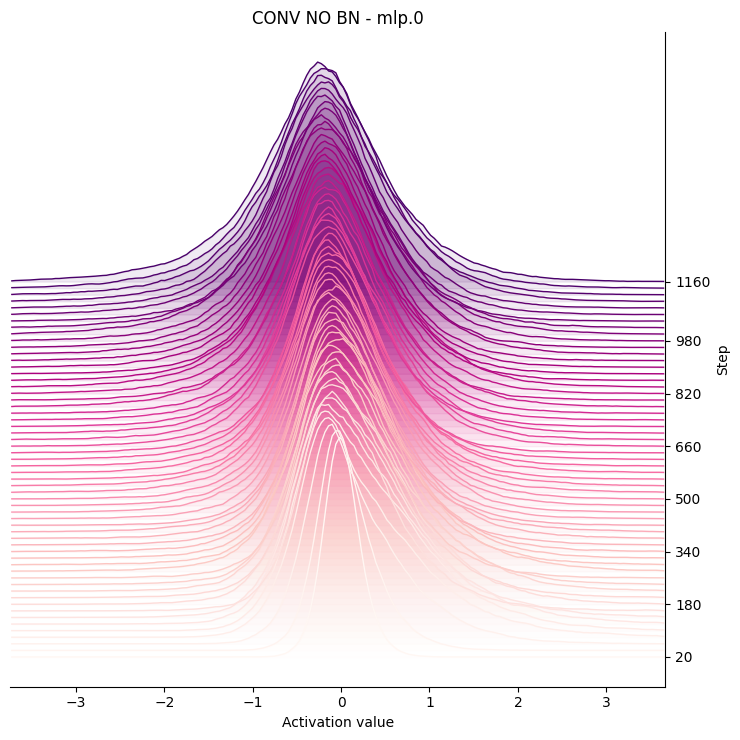

In [ ]:
if __name__ == "__main__":
    # ---- ConvMLP
    run_experiment(
        model_type="conv",
        epochs=3,
        batch_size=128,
        log_every=20,
        lr=0.1,
        out_dir=r"C:\Users\ryans\Desktop\projet_programation\Advanced_ML_BN_2025\image\plots"
    )

    # ---- MLP
    run_experiment(
        model_type="mlp",
        epochs=3,
        batch_size=128,
        log_every=20,
        lr=0.1,
        out_dir=r"C:\Users\ryans\Desktop\projet_programation\Advanced_ML_BN_2025\image\plots"
    )